In [1]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import os
from tqdm.auto import tqdm
import shutil
import random

import torch
import torchvision

from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets, utils
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import json

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import sklearn.metrics as met
import scipy.io

random.seed(42)

In [2]:
path = 'datasets/cars'

train = os.listdir(path+'/train')
test = os.listdir(path+'/test')
valid = os.listdir(path+'/valid')

data_train = []
train_labels = []
for i in range(len(train)):
    aux = os.listdir(path+'/train/'+train[i])
    data_train.append(aux)
    train_labels.append(train[i])
    
data_test = []
test_labels = []
for i in range(len(test)):
    aux = os.listdir(path+'/test/'+test[i])
    data_test.append(aux)
    test_labels.append(test[i])
    
data_valid = []
valid_labels = []
for i in range(len(valid)):
    aux = os.listdir(path+'/valid/'+valid[i])
    data_valid.append(aux)
    valid_labels.append(valid[i])

In [ ]:
len(data_train)

In [3]:
# Define the transforms to be performed over every subset instance
train_transforms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
test_transforms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])
valid_transforms = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

# Map the training and testing subsets 
train_data = datasets.ImageFolder(path+'/train', transform=train_transforms)
test_data = datasets.ImageFolder(path+'/test', transform=test_transforms)
valid_data = datasets.ImageFolder(path+'/valid', transform=valid_transforms)

In [5]:
batch_size = 16

# PyTorch data loaders
train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_data, batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_data, batch_size, shuffle=True, num_workers=0)

In [6]:
mat = scipy.io.loadmat('cars_annos.mat') 
classes = []

for i in range(len(mat['class_names'][0])):
    name = mat['class_names'][0][i][0]
    name = name.replace(' ','_')
    print(name)
    classes.append(name)

AM_General_Hummer_SUV_2000
Acura_RL_Sedan_2012
Acura_TL_Sedan_2012
Acura_TL_Type-S_2008
Acura_TSX_Sedan_2012
Acura_Integra_Type_R_2001
Acura_ZDX_Hatchback_2012
Aston_Martin_V8_Vantage_Convertible_2012
Aston_Martin_V8_Vantage_Coupe_2012
Aston_Martin_Virage_Convertible_2012
Aston_Martin_Virage_Coupe_2012
Audi_RS_4_Convertible_2008
Audi_A5_Coupe_2012
Audi_TTS_Coupe_2012
Audi_R8_Coupe_2012
Audi_V8_Sedan_1994
Audi_100_Sedan_1994
Audi_100_Wagon_1994
Audi_TT_Hatchback_2011
Audi_S6_Sedan_2011
Audi_S5_Convertible_2012
Audi_S5_Coupe_2012
Audi_S4_Sedan_2012
Audi_S4_Sedan_2007
Audi_TT_RS_Coupe_2012
BMW_ActiveHybrid_5_Sedan_2012
BMW_1_Series_Convertible_2012
BMW_1_Series_Coupe_2012
BMW_3_Series_Sedan_2012
BMW_3_Series_Wagon_2012
BMW_6_Series_Convertible_2007
BMW_X5_SUV_2007
BMW_X6_SUV_2012
BMW_M3_Coupe_2012
BMW_M5_Sedan_2010
BMW_M6_Convertible_2010
BMW_X3_SUV_2012
BMW_Z4_Convertible_2012
Bentley_Continental_Supersports_Conv._Convertible_2012
Bentley_Arnage_Sedan_2009
Bentley_Mulsanne_Sedan_2011
Ben

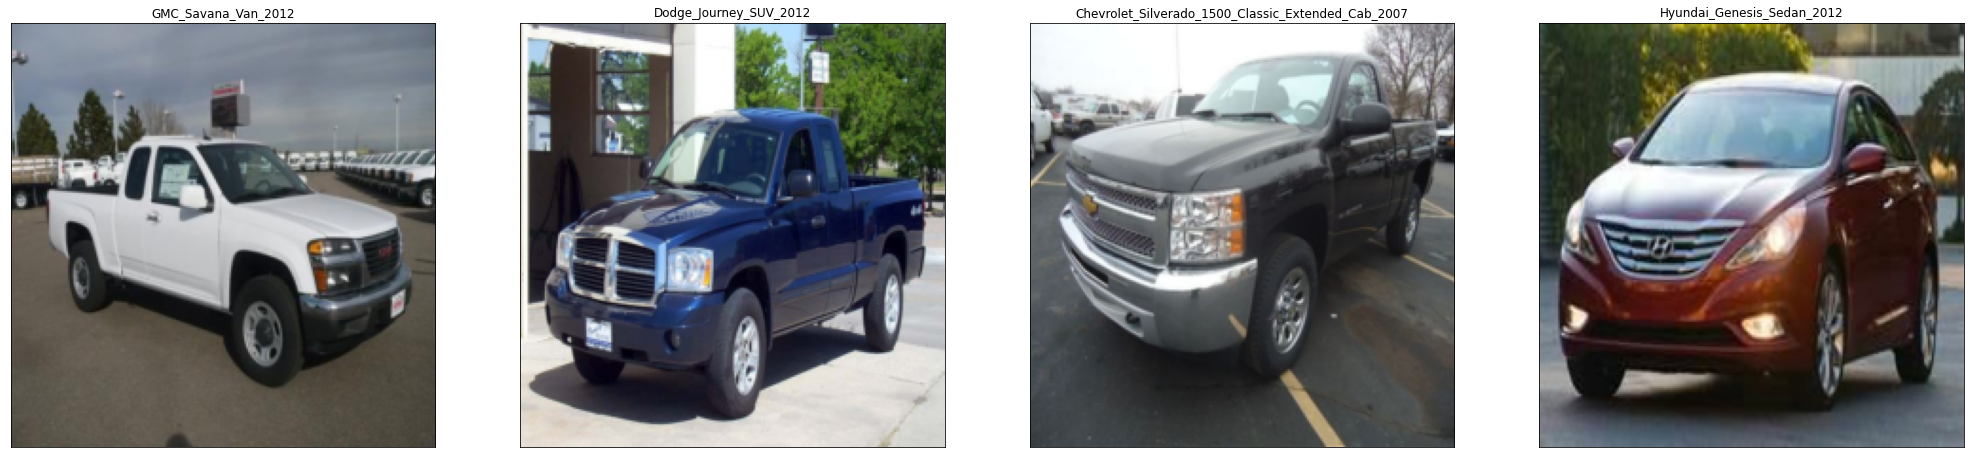

In [7]:
# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.permute(0,2,3,1).numpy()

# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(35, 15))
for idx in range(0,4):
    ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(classes[labels[idx].numpy()])

## Loading the Pretrained Model

In [8]:
pretrained_model = torch.load('model.pt')
pretrained_model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
#device = "cuda" if torch.cuda.is_available() else "cpu"
device = 'cpu'
pretrained_model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [10]:
# define a loss function
criterion = nn.CrossEntropyLoss()

In [12]:
# Let's define a test function to evaluate the model
def test(model):
    # initialize tensor and lists to monitor test loss and accuracy
    test_loss = torch.zeros(1)
    class_correct = list(0. for i in range(196))
    class_total = list(0. for i in range(196))

    test_loss = test_loss.to(device)

    # set the module to evaluation mode
    model.eval()

    for batch_i, data in tqdm(enumerate(test_loader),total=len(test_loader)):
      
        # get the input images and their corresponding labels
        inputs, labels = data

        # move inputs and labels to GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # forward pass to get outputs
        outputs = model(inputs)

        # calculate the loss
        loss = criterion(outputs, labels)

        # update average test loss 
        test_loss = test_loss + ((torch.ones(1).to(device) / (batch_i + 1)) * (loss.data - test_loss))

        # get the predicted class from the maximum value in the output-list of class scores
        _, predicted = torch.max(outputs.data, 1)

        # compare predictions to true label
        # this creates a `correct` Tensor that holds the number of correctly classified images in a batch
        correct = np.squeeze(predicted.eq(labels.data.view_as(predicted)))

        # calculate test accuracy for *each* object class
        # we get the scalar value of correct items for a class, by calling `correct[i].item()`
        for i in range(len(labels)):
            label = labels.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

    print('Test Loss:',test_loss.cpu().numpy()[0])

    for i in range(196):
        if class_total[i] > 0:
            print('')
            print('Test Accuracy of ',classes[i],':', 100 * class_correct[i] / class_total[i],'%')
        else:
            print('')
            print('Test Accuracy of ',classes[i],': No training examples')

test(pretrained_model)

100%|█████████████████████████████████████████| 102/102 [00:20<00:00,  4.89it/s]

Test Loss: 2.3977032

Test Accuracy of  AM_General_Hummer_SUV_2000 : 75.0 %

Test Accuracy of  Acura_RL_Sedan_2012 : 58.333333333333336 %

Test Accuracy of  Acura_TL_Sedan_2012 : 80.0 %

Test Accuracy of  Acura_TL_Type-S_2008 : 57.142857142857146 %

Test Accuracy of  Acura_TSX_Sedan_2012 : 63.63636363636363 %

Test Accuracy of  Acura_Integra_Type_R_2001 : 50.0 %

Test Accuracy of  Acura_ZDX_Hatchback_2012 : 62.5 %

Test Accuracy of  Aston_Martin_V8_Vantage_Convertible_2012 : 0.0 %

Test Accuracy of  Aston_Martin_V8_Vantage_Coupe_2012 : 0.0 %

Test Accuracy of  Aston_Martin_Virage_Convertible_2012 : 50.0 %

Test Accuracy of  Aston_Martin_Virage_Coupe_2012 : 77.77777777777777 %

Test Accuracy of  Audi_RS_4_Convertible_2008 : 42.857142857142854 %

Test Accuracy of  Audi_A5_Coupe_2012 : 44.44444444444444 %

Test Accuracy of  Audi_TTS_Coupe_2012 : 66.66666666666667 %

Test Accuracy of  Audi_R8_Coupe_2012 : 40.0 %

Test Accuracy of  Audi_V8_Sedan_1994 : 33.333333333333336 %

Test Accuracy of

In [ ]:
pretrained_model.to(device)

## Visualize a Sample Test Result

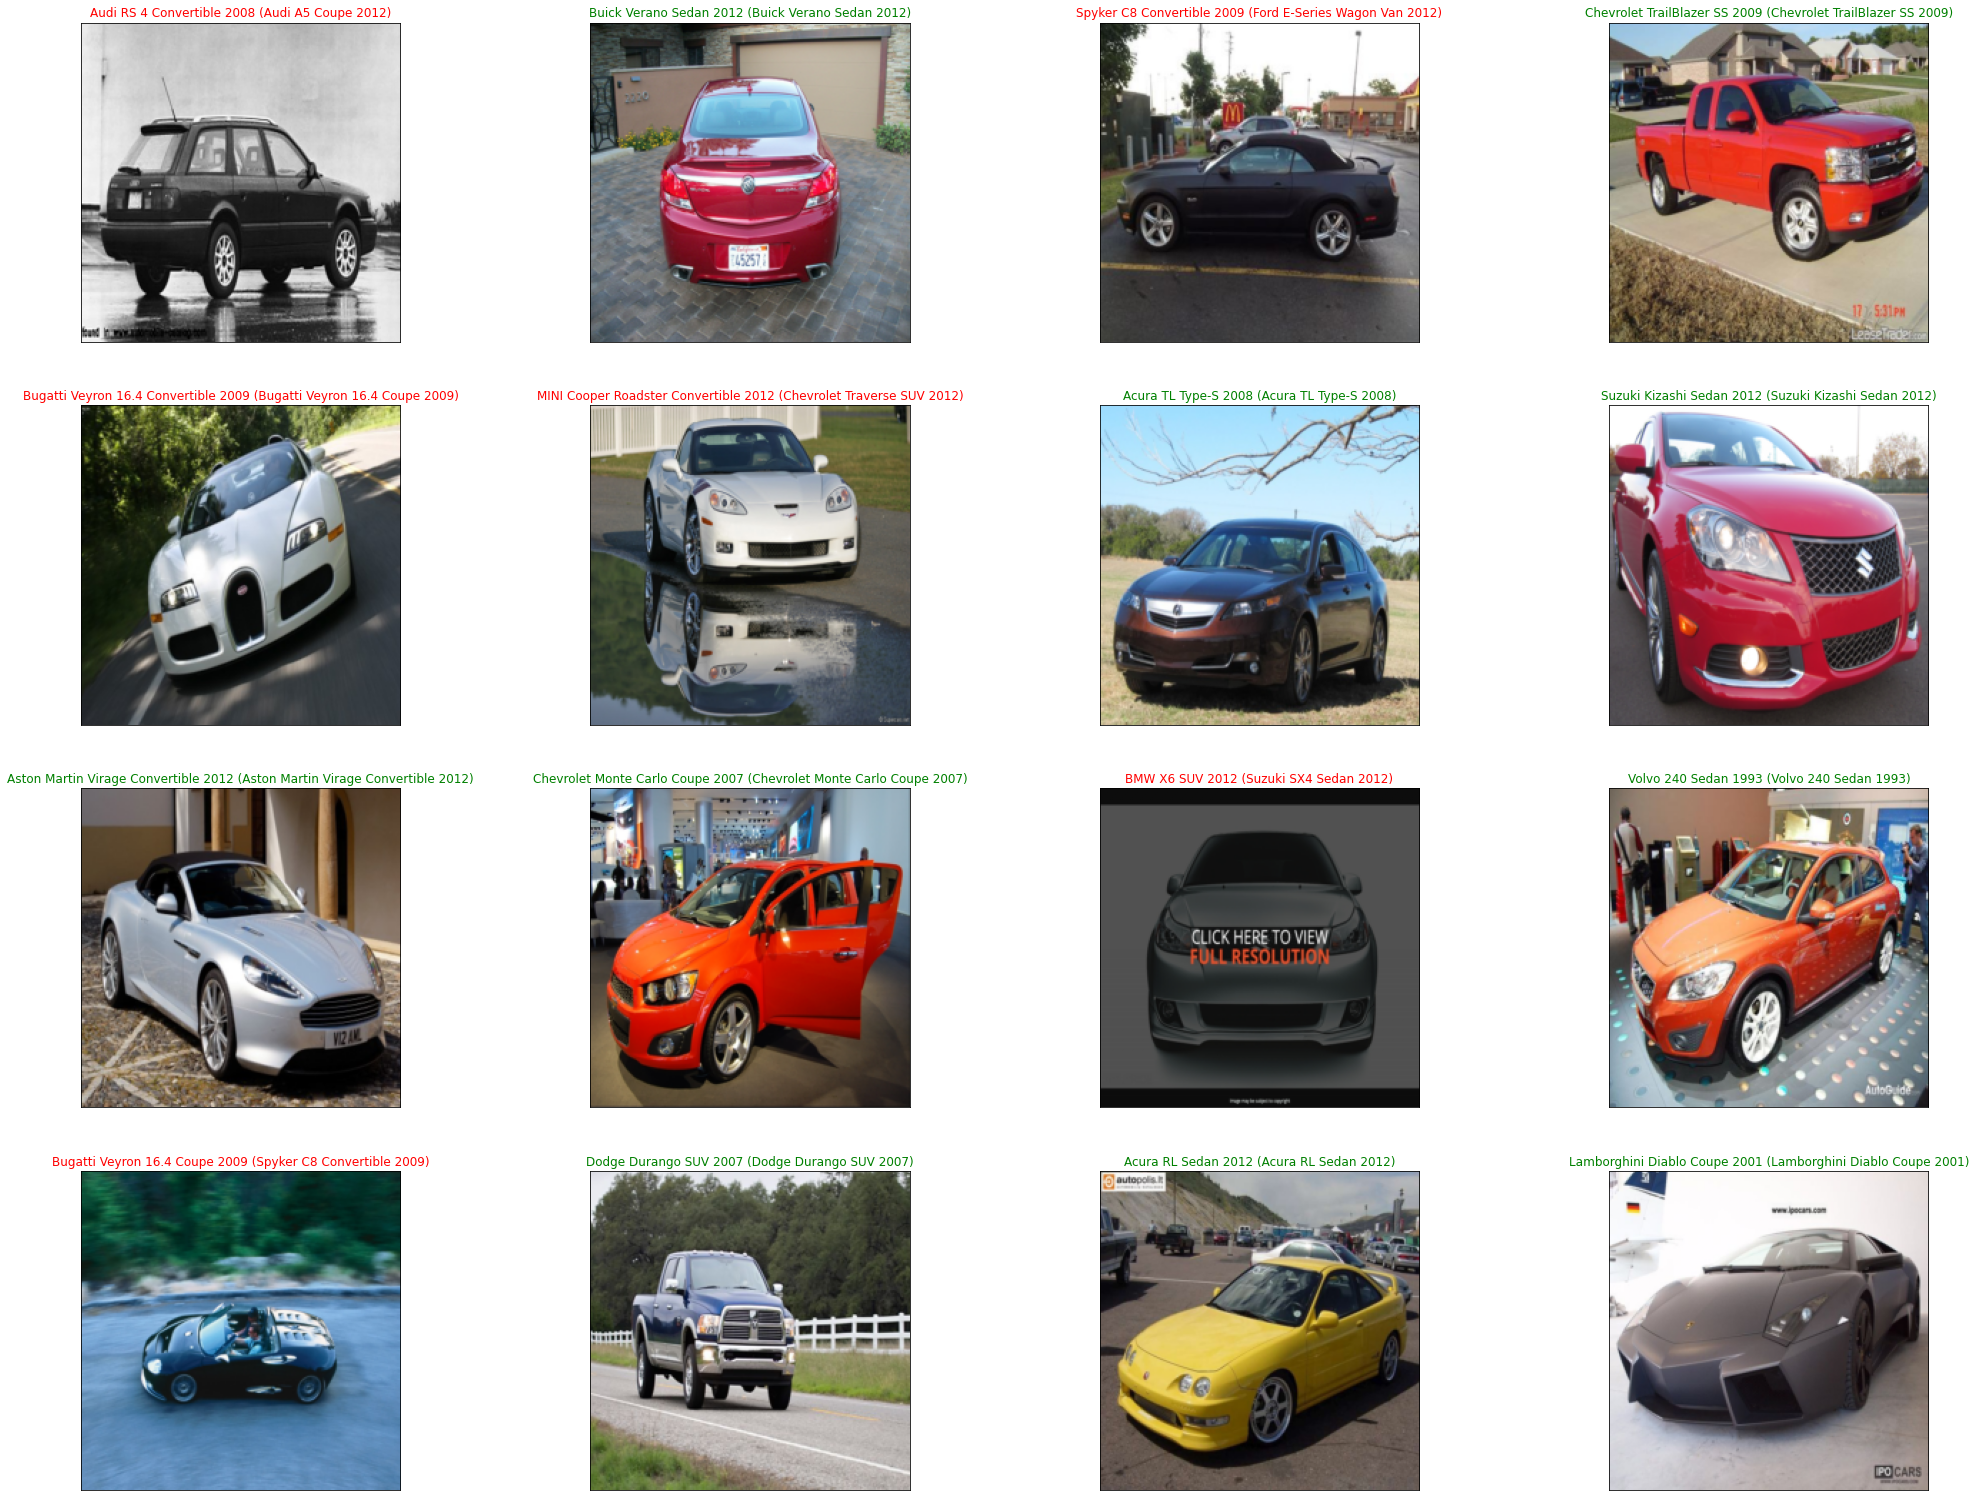

In [13]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# move inputs and labels to GPU
images, labels = images.to(device), labels.to(device)

# get predictions
preds = np.squeeze(pretrained_model(images).data.max(1, keepdim=True)[1].cpu().numpy())

images = images.permute(0,2,3,1).cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(35, 27))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(4, 4, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(""+str(classes[preds[idx]].replace('_',' '))+" ("+str(classes[labels[idx]].replace('_',' '))+")",color=("green" if preds[idx]==labels[idx] else "red"))

(1619,)
Accuracy Score:  977
Accuracy Score (normalized):  0.6034589252625078
F1 Score (weighted):  0.6040938453381535
Confussion matrix:
[[ 6  0  0 ...  0  0  0]
 [ 0  7  0 ...  0  0  0]
 [ 0  0  4 ...  0  0  0]
 ...
 [ 0  0  0 ... 11  0  0]
 [ 0  0  0 ...  0  4  0]
 [ 0  0  0 ...  0  0  7]]


<AxesSubplot:>

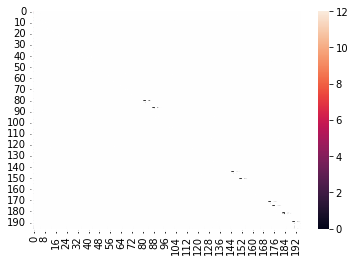

In [18]:
import seaborn as sn


labels = labels
print(labels.shape)
accuracy_n = met.accuracy_score(labels, preds)
accuracy = met.accuracy_score(labels, preds, normalize = False)
f1_score_w = met.f1_score(labels, preds, average = 'weighted')
conf_mat = met.confusion_matrix(labels, preds)

print("Accuracy Score: ", accuracy)
print("Accuracy Score (normalized): ", accuracy_n)
print("F1 Score (weighted): ", f1_score_w)
print("Confussion matrix:")
cm=met.confusion_matrix(labels, preds)
print(cm)
sn.heatmap(cm, annot=True)